In [1]:
import pandas as pd
import shap
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

/Users/stefania/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/dataset_manipulated_cl2.csv')

In [3]:
df_manipulated = pd.read_csv('../data/dataset_manipulated.csv', index_col=0)
df_original = pd.read_excel('../data/Cohort_anonymized_data_VOCs.xlsx', index_col=0)

In [ ]:
#add column com_nocom to df_manipulated by merging through the index with df_original
df_manipulated = df_manipulated.merge(df_original[['com_nocom']], left_index=True, right_index=True)

['age_enrollment',
 'gender',
 'ethnicity',
 'vax_DTP',
 'vax_IPV/OPV',
 'vax_HBV',
 'vax_Hib',
 'vax_MPR',
 'vax_Varicella',
 'vax_PCV',
 'vax_ACWY',
 'vax_MenB',
 'vax_Rotavirus',
 'vax_BCG',
 'vax_other',
 'vax_unvaccinated',
 'vax_unknown',
 'vax_flu_2019-2020',
 'vax_flu_2020_2021',
 'vax_covid_firstdose',
 'vax_covid_firstdose_date',
 'vax_covid_seconddose',
 'vax_covid_seconddose_date',
 'vax_covid_thirddose',
 'vax_covid_thirddose_date',
 'com_prematurity',
 'com_obesity',
 'com_diabetes',
 'com_asthma',
 'com_chronic-resp-disease',
 'com_congenital-heart-disease',
 'com_neurological-disease',
 'enrollment_date',
 'baseline_date_infection',
 'baseline_definition',
 'WHO_stage',
 'management',
 'covid_symptoms',
 'sym_fever',
 'sym_rhinitis',
 'sym_cough',
 'sym_dyspnea',
 'sym_ear-pain',
 'sym_myalgia',
 'sym_arthralgia',
 'sym_sore-throat',
 'sym_conjunctivitis',
 'sym_asthenia',
 'sym_confusion',
 'sym_abdominal-pain',
 'sym_nausea/vomit',
 'sym_diarrhea',
 'sym_lack-appetite

In [6]:
df['com_nocom'] = df_manipulated['com_nocom'].values
df['at_least_one_comorbidity'] = df['com_nocom'].replace({0:1, 1:0})

In [ ]:
#Check number of people with at least 1 comorbidity
print(df[df['at_least_one_comorbidity'] == 1].shape[0] / df.shape[0])
print(df[df['at_least_one_comorbidity'] == 0].shape[0] / df.shape[0])

0.7487091222030982

In [43]:
df

,age_enrollment,gender,ethnicity,vax_DTP,vax_IPV/OPV,vax_HBV,vax_Hib,vax_MPR,vax_Varicella,vax_PCV,...,duration_polyadenopathy,duration_skin-rash,duration_pneumonia,duration_other,median_sym_duration,infection_category,VOC,hex_vax,Cluster,com_nocom
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,1,2.0,1,0,0,2,1
1,0,1,5,1,1,1,1,0,0,0,...,0,0,0,0,2.0,1,0,1,0,1
2,0,0,3,1,1,1,1,0,0,0,...,0,0,0,0,4.0,1,0,1,2,1
3,0,0,5,1,1,1,1,0,0,1,...,0,0,0,0,1.0,1,0,1,1,1
4,0,0,5,1,1,1,1,1,1,1,...,0,0,0,0,1.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,18,0,5,1,1,1,1,1,0,1,...,0,0,0,0,0.0,0,0,1,0,1
577,19,0,5,1,1,1,1,1,1,1,...,0,0,0,3,3.0,1,0,1,1,1
578,19,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,1
579,19,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,1


In [44]:
# replace data for covid-19 vaccination -1 with 0
df['vax_covid_firstdose'] = df['vax_covid_firstdose'].replace({-1:0})
df['vax_covid_firstdose'].value_counts()

vax_covid_firstdose
0.0    529
1.0     52
Name: count, dtype: int64

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Define independent variables
predictors =  ['age_enrollment','gender', 'hex_vax',
              'com_prematurity',  'com_asthma', 'com_neurological-disease',
               'VOC', 'vax_flu_2020_2021', 'at_least_one_comorbidity','vax_covid_firstdose']

#Independent variables set 
X = df[predictors] 
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
print(vif_data)

                    feature       VIF
0            age_enrollment  3.492427
1                    gender  2.094747
2                   hex_vax  3.733542
3           com_prematurity  1.086922
4                com_asthma  1.118013
5  com_neurological-disease  1.042200
6                       VOC  1.496146
7         vax_flu_2020_2021  1.172553
8  at_least_one_comorbidity  1.590721
9       vax_covid_firstdose  1.461041


In [ ]:
predictors =  ['age_enrollment','gender', 'hex_vax',
              'com_prematurity', 'com_obesity',  'com_asthma', 'com_neurological-disease',
               'VOC', 'vax_flu_2020_2021', 'at_least_one_comorbidity','vax_covid_firstdose']

X = df.loc[:, predictors] 
y = df['Cluster']

# Training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Definition of categorical features
categorical_features = [col in ['gender', 'hex_vax',
              'com_prematurity', 'com_obesity',  'com_asthma', 'com_neurological-disease',
               'VOC', 'vax_flu_2020_2021', 'at_least_one_comorbidity','vax_covid_firstdose'] for col in X_train.columns]

# Oversampling with SMOTE only on the training set
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)
print("Classes distribution after SMOTE:", Counter(y_train_resampled))

# Cross-validation
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_dist,
    cv=stratified_kfold,
    scoring='accuracy',
    n_jobs=-1
)

# Save metrics
accuracy_scores = []
confusion_matrices = []
confusion_matrices_notnorm = []
auc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
SHAP_values_per_fold = []
shap_values_all = []

for train_index, test_index in stratified_kfold.split(X_train_resampled, y_train_resampled):
    X_train_cv, X_test_cv = X_train_resampled.iloc[train_index], X_train_resampled.iloc[test_index]
    y_train_cv, y_test_cv = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]
    
    # Fit model
    grid_search.fit(X_train_cv, y_train_cv)

    # model with best hyperparameters
    best_model = grid_search.best_estimator_

    # predictions
    predictions = best_model.predict(X_test_cv)

    #Compute metrics
    y_prob = best_model.predict_proba(X_test_cv) 
    auc_score = roc_auc_score(y_test_cv, y_prob, multi_class='ovr')
    auc_scores.append(auc_score)
    f1 = f1_score(y_test_cv, predictions, average='weighted')
    f1_scores.append(f1)
    precision = precision_score(y_test_cv, predictions, average='weighted')
    precision_scores.append(precision)
    recall = recall_score(y_test_cv, predictions, average='weighted')
    recall_scores.append(recall)
    accuracy = accuracy_score(y_test_cv, predictions)
    accuracy_scores.append(accuracy)

    cm = confusion_matrix(y_test_cv, predictions, normalize='true')
    cm_notnorm = confusion_matrix(y_test_cv, predictions)
    confusion_matrices.append(cm)
    confusion_matrices_notnorm.append(cm_notnorm)

    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X_test)
    
    shap_values_all.append(shap_values) # add shap for each fold
    for SHAPs in shap_values:
        SHAP_values_per_fold.append(SHAPs) #-#-#


Distribuzione classi dopo SMOTE: Counter({0: 302, 2: 302, 1: 302})


In [ ]:
# Accuracy
average_accuracy = np.mean(accuracy_scores)
lower_accuracy = np.percentile(accuracy_scores, 2.5)
upper_accuracy = np.percentile(accuracy_scores, 97.5)
print(f'Average Accuracy: {average_accuracy}')
print(f'95% Confidence Interval: [{lower_accuracy}, {upper_accuracy}]')

# AUC
average_auc = np.mean(auc_scores)
lower_auc = np.percentile(auc_scores, 2.5)
upper_auc = np.percentile(auc_scores, 97.5)
print(f'Average AUC: {average_auc}')
print(f'95% Confidence Interval: [{lower_auc}, {upper_auc}]')

# F1-score
average_f1 = np.mean(f1_scores)
lower_f1 = np.percentile(f1_scores, 2.5)
upper_f1 = np.percentile(f1_scores, 97.5)
print(f'Average F1-score: {average_f1}')
print(f'95% Confidence Interval: [{lower_f1}, {upper_f1}]')

# Precision
average_precision = np.mean(precision_scores)
lower_precision = np.percentile(precision_scores, 2.5)
upper_precision = np.percentile(precision_scores, 97.5)
print(f'Average Precision: {average_precision}')
print(f'95% Confidence Interval: [{lower_precision}, {upper_precision}]')

# Recall
average_recall = np.mean(recall_scores)
lower_recall = np.percentile(recall_scores, 2.5)
upper_recall = np.percentile(recall_scores, 97.5)
print(f'Average Recall: {average_recall}')
print(f'95% Confidence Interval: [{lower_recall}, {upper_recall}]')


Average Accuracy: 0.6148017728128226
95% Confidence Interval: [0.5477323781191183, 0.6651933701657459]
Average AUC: 0.7842856282647639
95% Confidence Interval: [0.7409108973490495, 0.8051949073446838]
Average F1-score: 0.6143528425566475
95% Confidence Interval: [0.5454353134559097, 0.6640081665194082]
Average Precision: 0.6186776637371663
95% Confidence Interval: [0.5483011995451709, 0.6685070508820896]
Average Recall: 0.6148017728128226
95% Confidence Interval: [0.5477323781191183, 0.6651933701657459]


In [ ]:
# Confusion matrix normalized
final_confusion_matrix = np.mean(confusion_matrices, axis=0)
# confidence interval for the confusion matrix
lower_confusion_matrix = np.percentile(confusion_matrices, 2.5, axis=0)
upper_confusion_matrix = np.percentile(confusion_matrices, 97.5, axis=0)
print('Normalized Final Confusion Matrix (Row-wise Normalization):')
print(final_confusion_matrix)
print('Confidence Interval:')
print(lower_confusion_matrix)
print(upper_confusion_matrix)

Normalized Final Confusion Matrix (Row-wise Normalization):
[[0.54628415 0.26191257 0.19180328]
 [0.21169399 0.63961749 0.14868852]
 [0.15196721 0.18928962 0.65874317]]
Confidence Interval:
[[0.48909836 0.21311475 0.10166667]
 [0.12       0.50262295 0.10166667]
 [0.05666667 0.1        0.62      ]]
[[0.58237705 0.345      0.27959016]
 [0.29459016 0.76166667 0.24939891]
 [0.22489071 0.29666667 0.7147541 ]]


In [ ]:
final_confusion_matrix_notnorm = np.rint(np.mean(confusion_matrices_notnorm, axis=0))  # Arrotondamento
lower_confusion_matrix_notnorm = np.rint(np.percentile(confusion_matrices_notnorm, 2.5, axis=0))
upper_confusion_matrix_notnorm = np.rint(np.percentile(confusion_matrices_notnorm, 97.5, axis=0))

print('Final Confusion Matrix (Not Normalized, Rounded to Integers):')
print(final_confusion_matrix_notnorm.astype(int)) 
print('Confidence Interval:')
print(lower_confusion_matrix_notnorm.astype(int))
print(upper_confusion_matrix_notnorm.astype(int))

Final Confusion Matrix (Not Normalized, Rounded to Integers):
[[33 16 12]
 [13 39  9]
 [ 9 11 40]]
Confidence Interval:
[[29 13  6]
 [ 7 31  6]
 [ 3  6 37]]
[[35 21 17]
 [18 46 15]
 [14 18 44]]


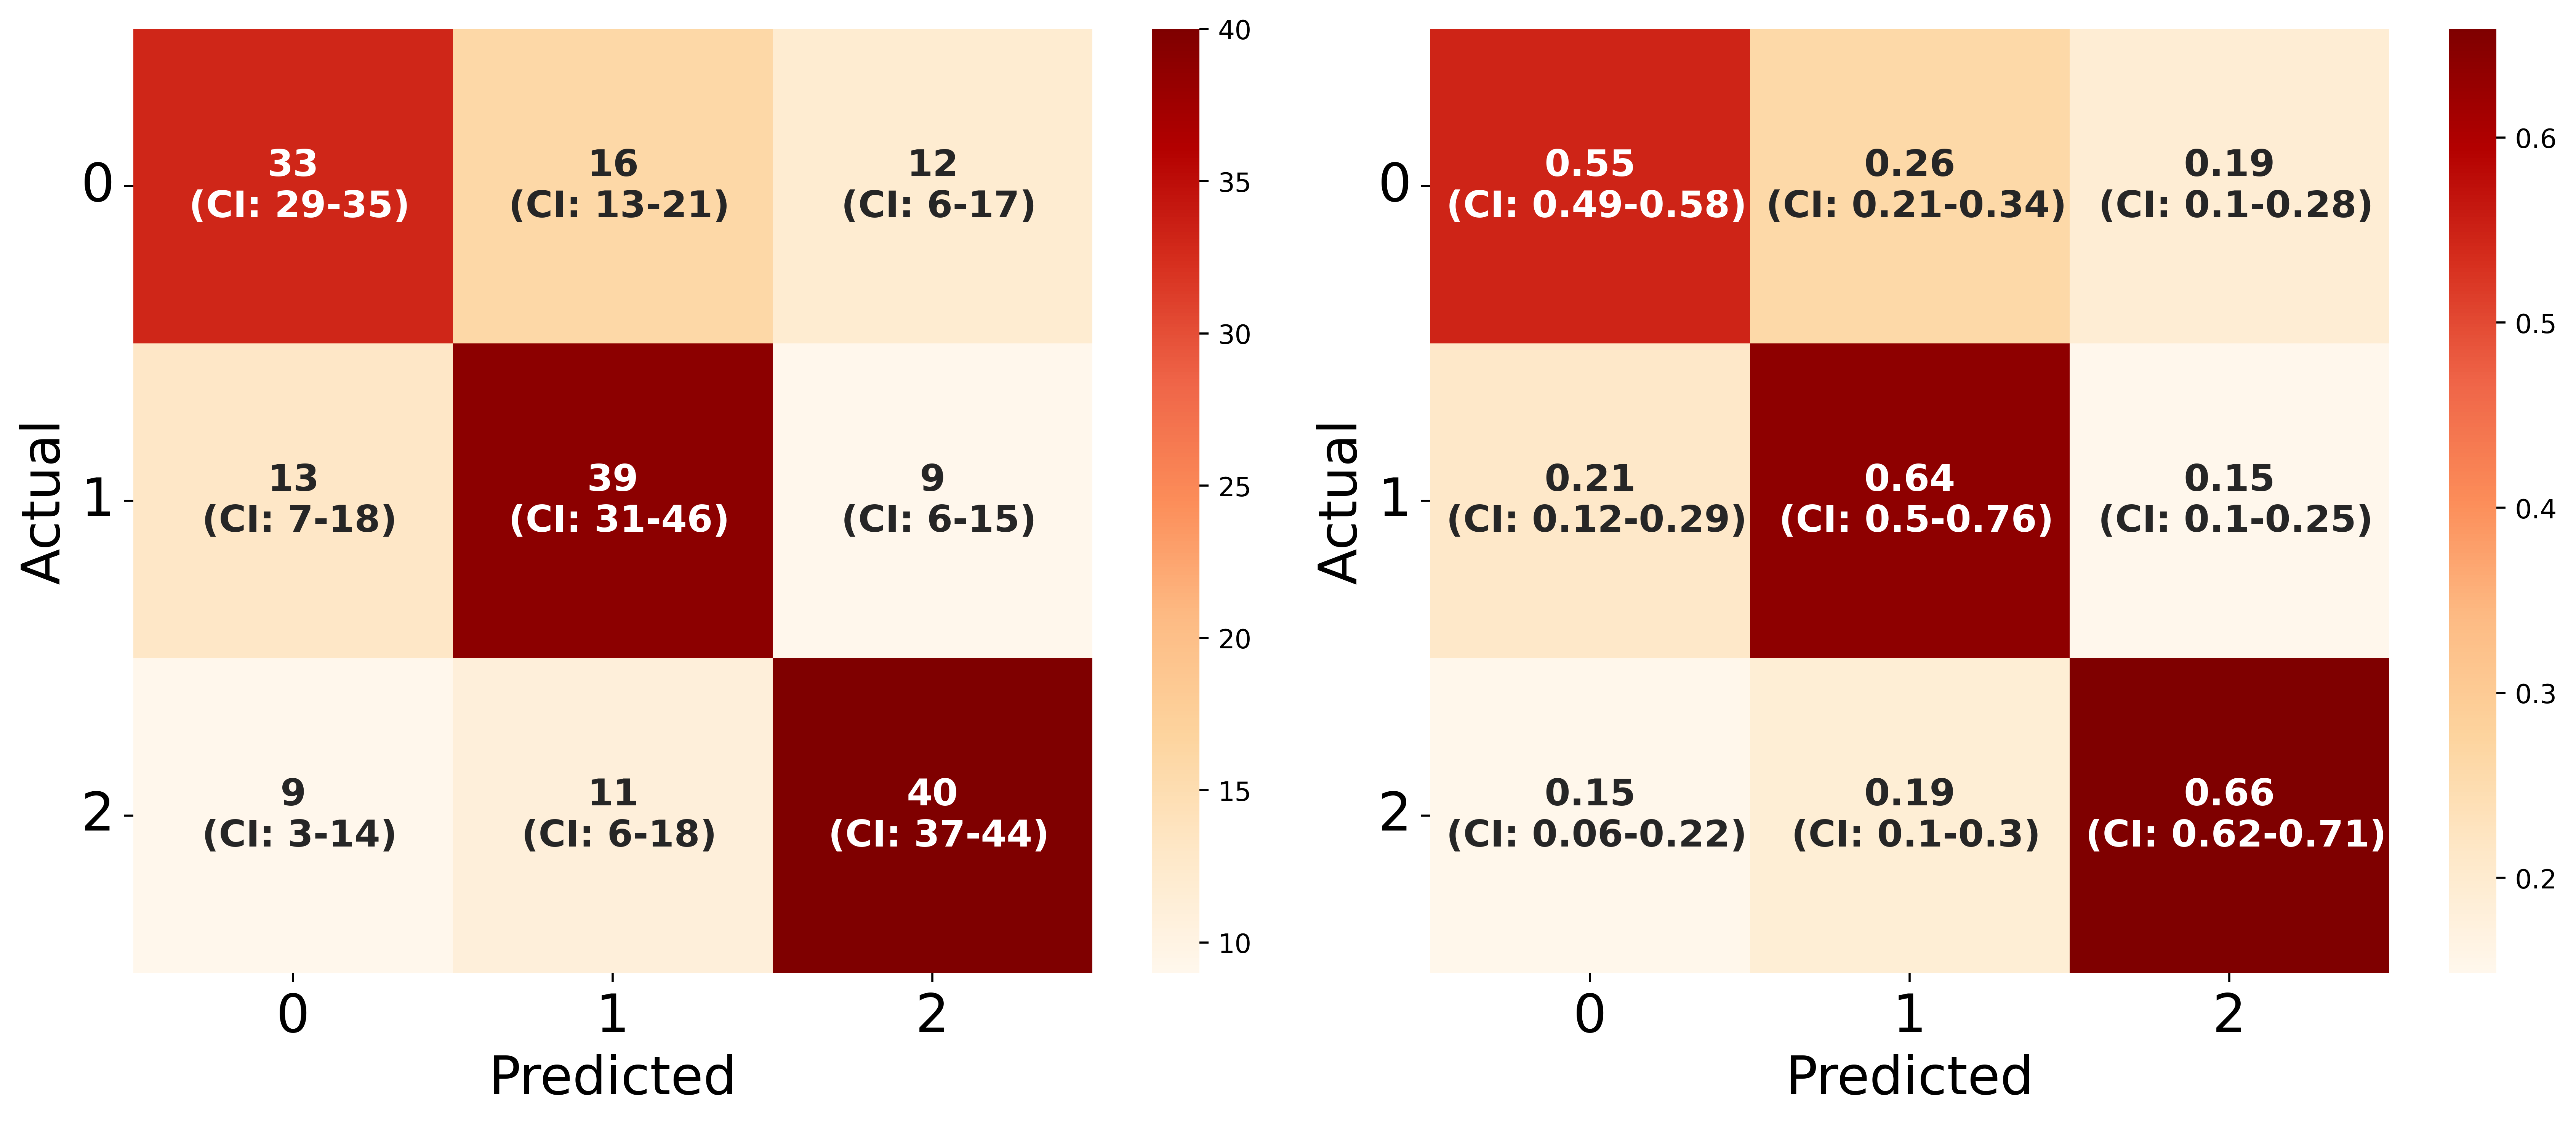

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=500)

def format_ci(mean_matrix, lower_matrix, upper_matrix):
    """
    Format matrix annotations to include confidence intervals.
    """
    return np.array([[f"{int(mean_matrix[i, j])}\n (CI: {int(lower_matrix[i, j])}-{int(upper_matrix[i, j])})" 
                      for j in range(mean_matrix.shape[1])] for i in range(mean_matrix.shape[0])])

def format_ci_norm(mean_matrix, lower_matrix, upper_matrix):
    """
    Format matrix annotations to include confidence intervals.
    """
    return np.array([[f"{np.round(mean_matrix[i, j], 2)}\n (CI: {np.round(lower_matrix[i, j],2)}-{np.round(upper_matrix[i, j],2)})" 
                      for j in range(mean_matrix.shape[1])] for i in range(mean_matrix.shape[0])])

annot_conf_matrix_notnorm = format_ci(final_confusion_matrix_notnorm, lower_confusion_matrix_notnorm, upper_confusion_matrix_notnorm)
annot_conf_matrix = format_ci_norm(final_confusion_matrix, lower_confusion_matrix, upper_confusion_matrix)

sns.heatmap(final_confusion_matrix_notnorm.astype(int), annot=annot_conf_matrix_notnorm, fmt='', cmap='OrRd', 
            annot_kws={ "size": 14, "fontweight": "bold"}, ax=ax1)
ax1.set_xlabel('Predicted', fontsize=20)
ax1.set_ylabel('Actual', fontsize=20)

sns.heatmap(final_confusion_matrix, annot=annot_conf_matrix, fmt='', cmap='OrRd', 
            annot_kws={"size": 14, "fontweight": "bold"}, ax=ax2)

ax2.set_xlabel('Predicted', fontsize=20)
ax2.set_ylabel('Actual', fontsize=20)
# Increase ticks
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20, rotation=360)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20, rotation=360)
plt.tight_layout()
plt.show()

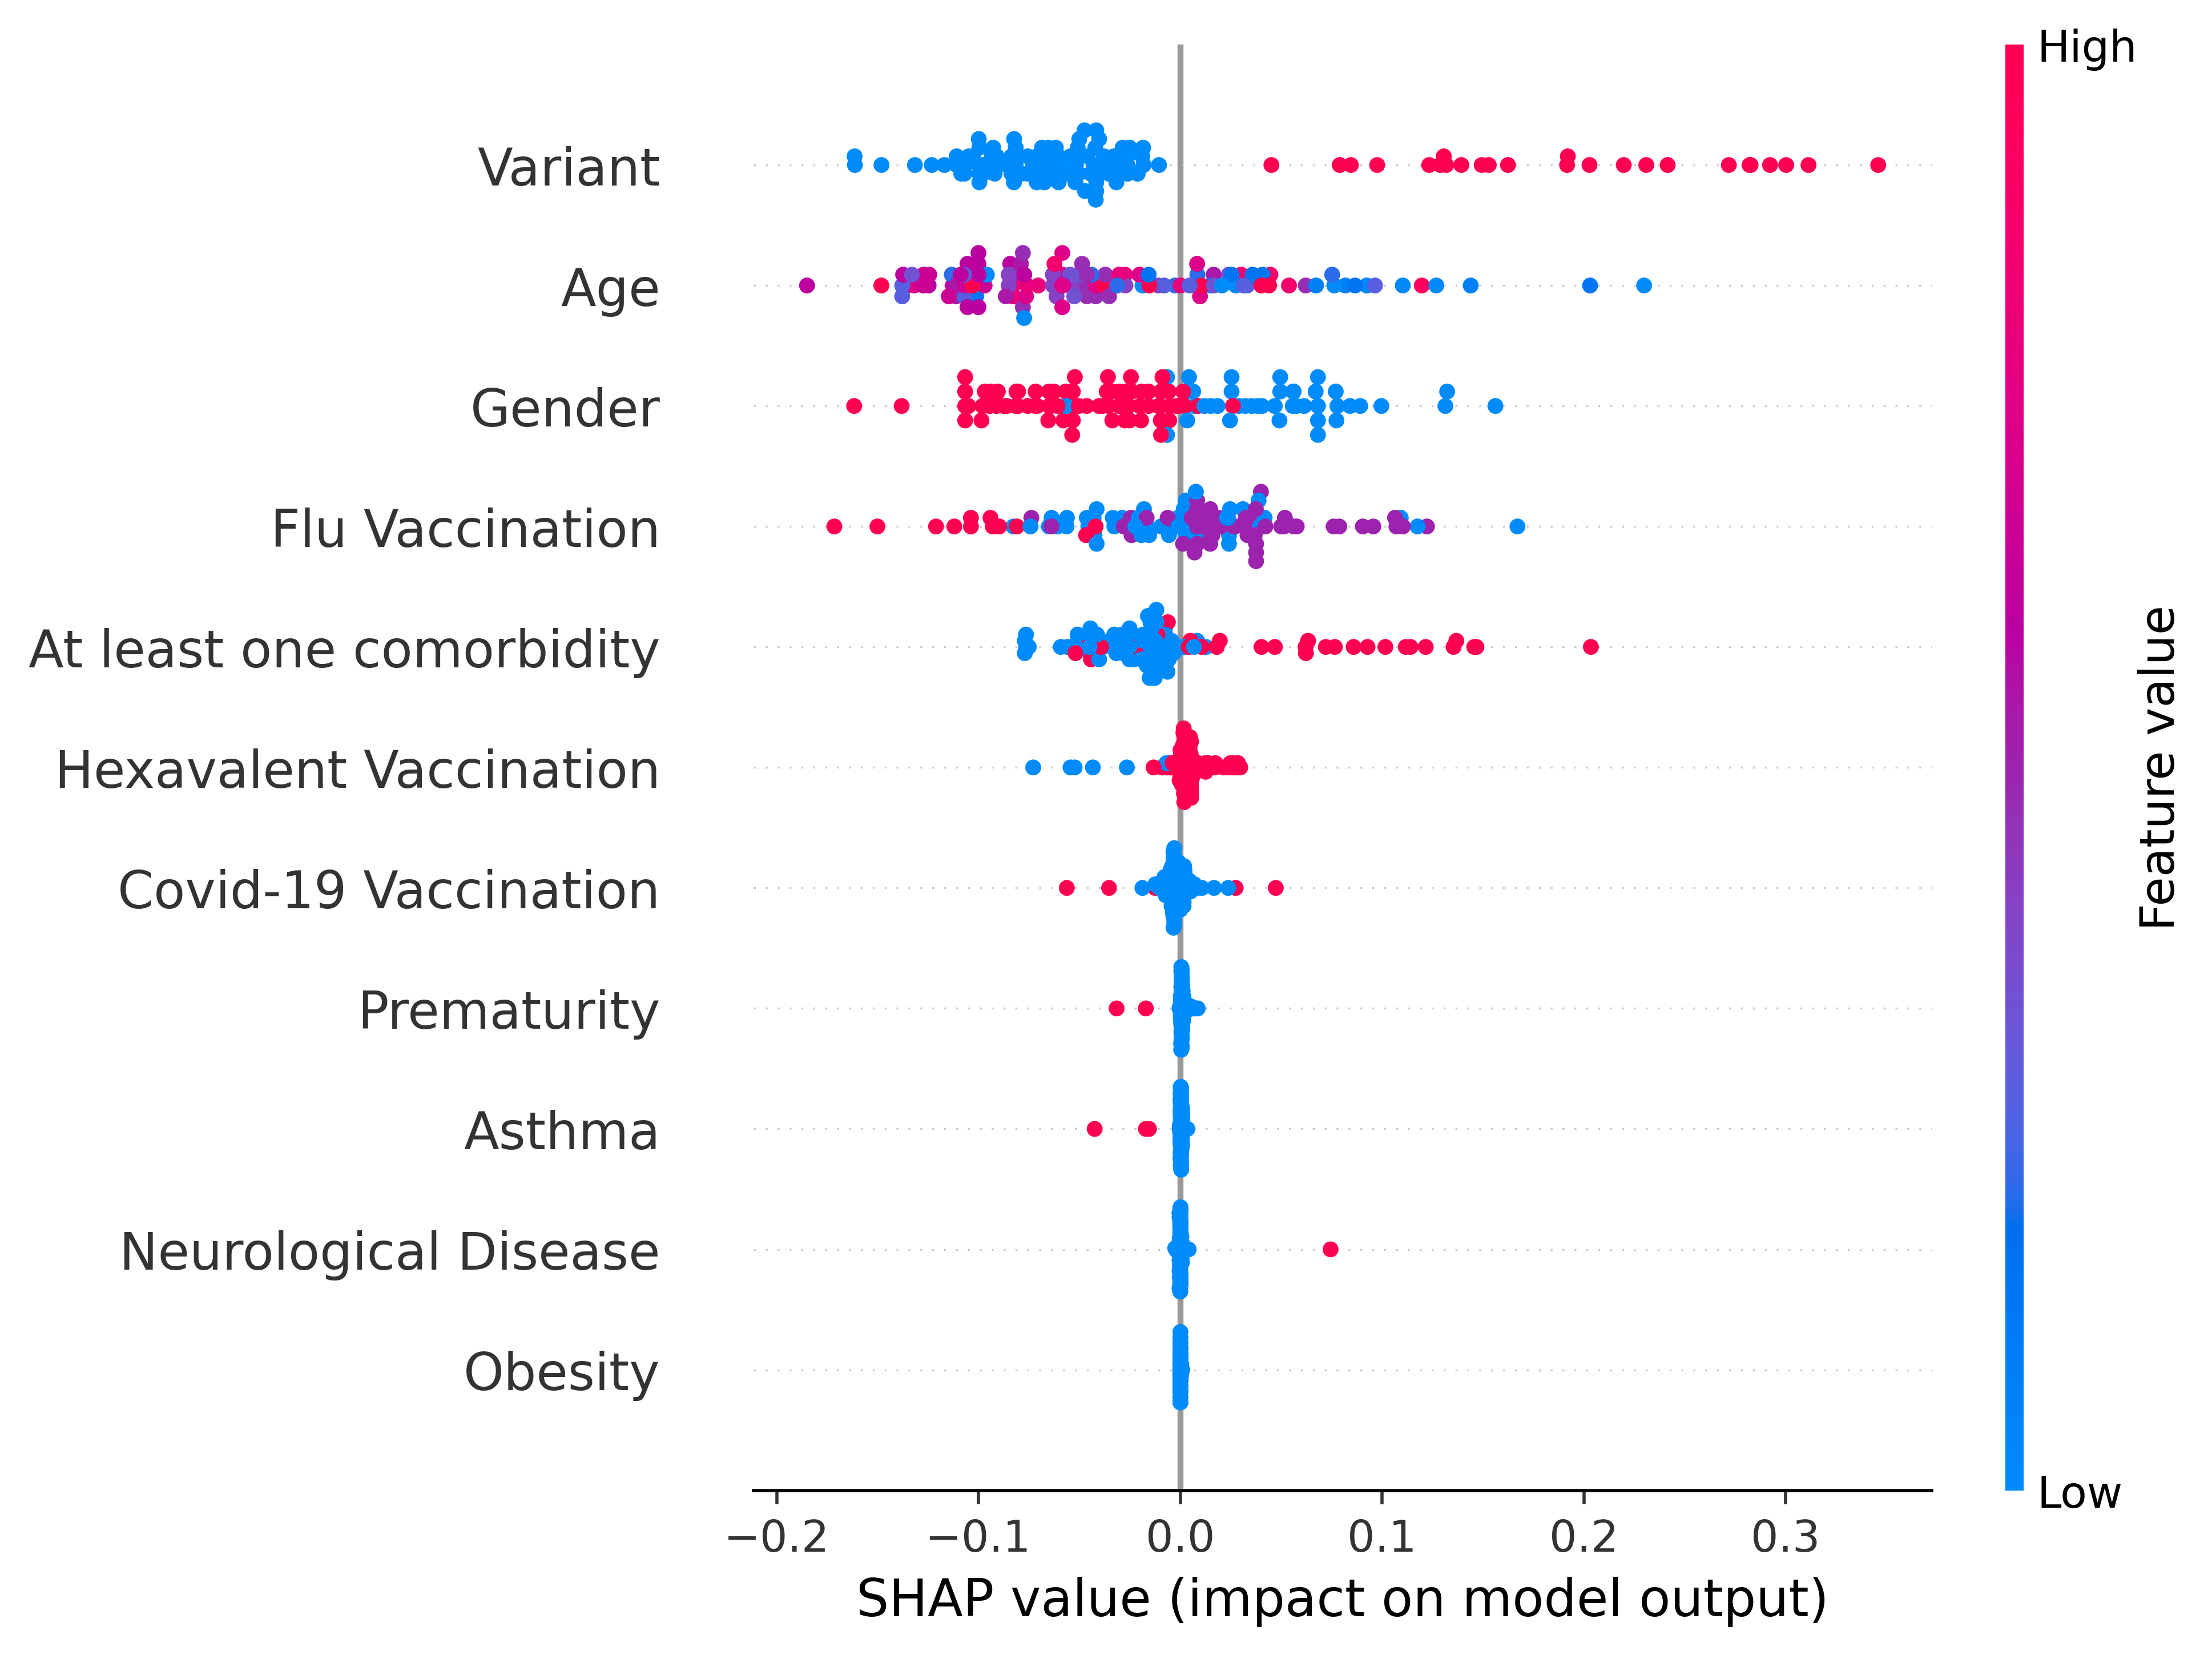

In [ ]:
X.rename(columns={'age_enrollment': 'Age', 'gender': 'Gender',
                  'hex_vax': 'Hexavalent Vaccination', 'VOC': 'Variant',
                  'vax_covid_firstdose': 'Covid-19 Vaccination', 
                  'com_obesity': 'Obesity', 'com_neurological-disease': 'Neurological Disease',
                    'com_asthma': 'Asthma', 'com_prematurity': 'Prematurity',
                    'vax_flu_2020_2021': 'Flu Vaccination', 'at_least_one_comorbidity': 'At least one comorbidity'
                  }, inplace=True)
class_index = 2 

shap_values_numeric = np.array([shap_values.values for shap_values in shap_values_all])
shap_values_class_mean = np.mean(shap_values_numeric, axis=0)[:, :, class_index]  # (117, 11)

plt.figure(dpi=500)
shap.summary_plot(
    shap_values_class_mean, 
    X_test, 
    plot_type="dot", 
    color=plt.get_cmap("coolwarm"),  # Rosa-blu
    feature_names=X.columns.tolist()
)

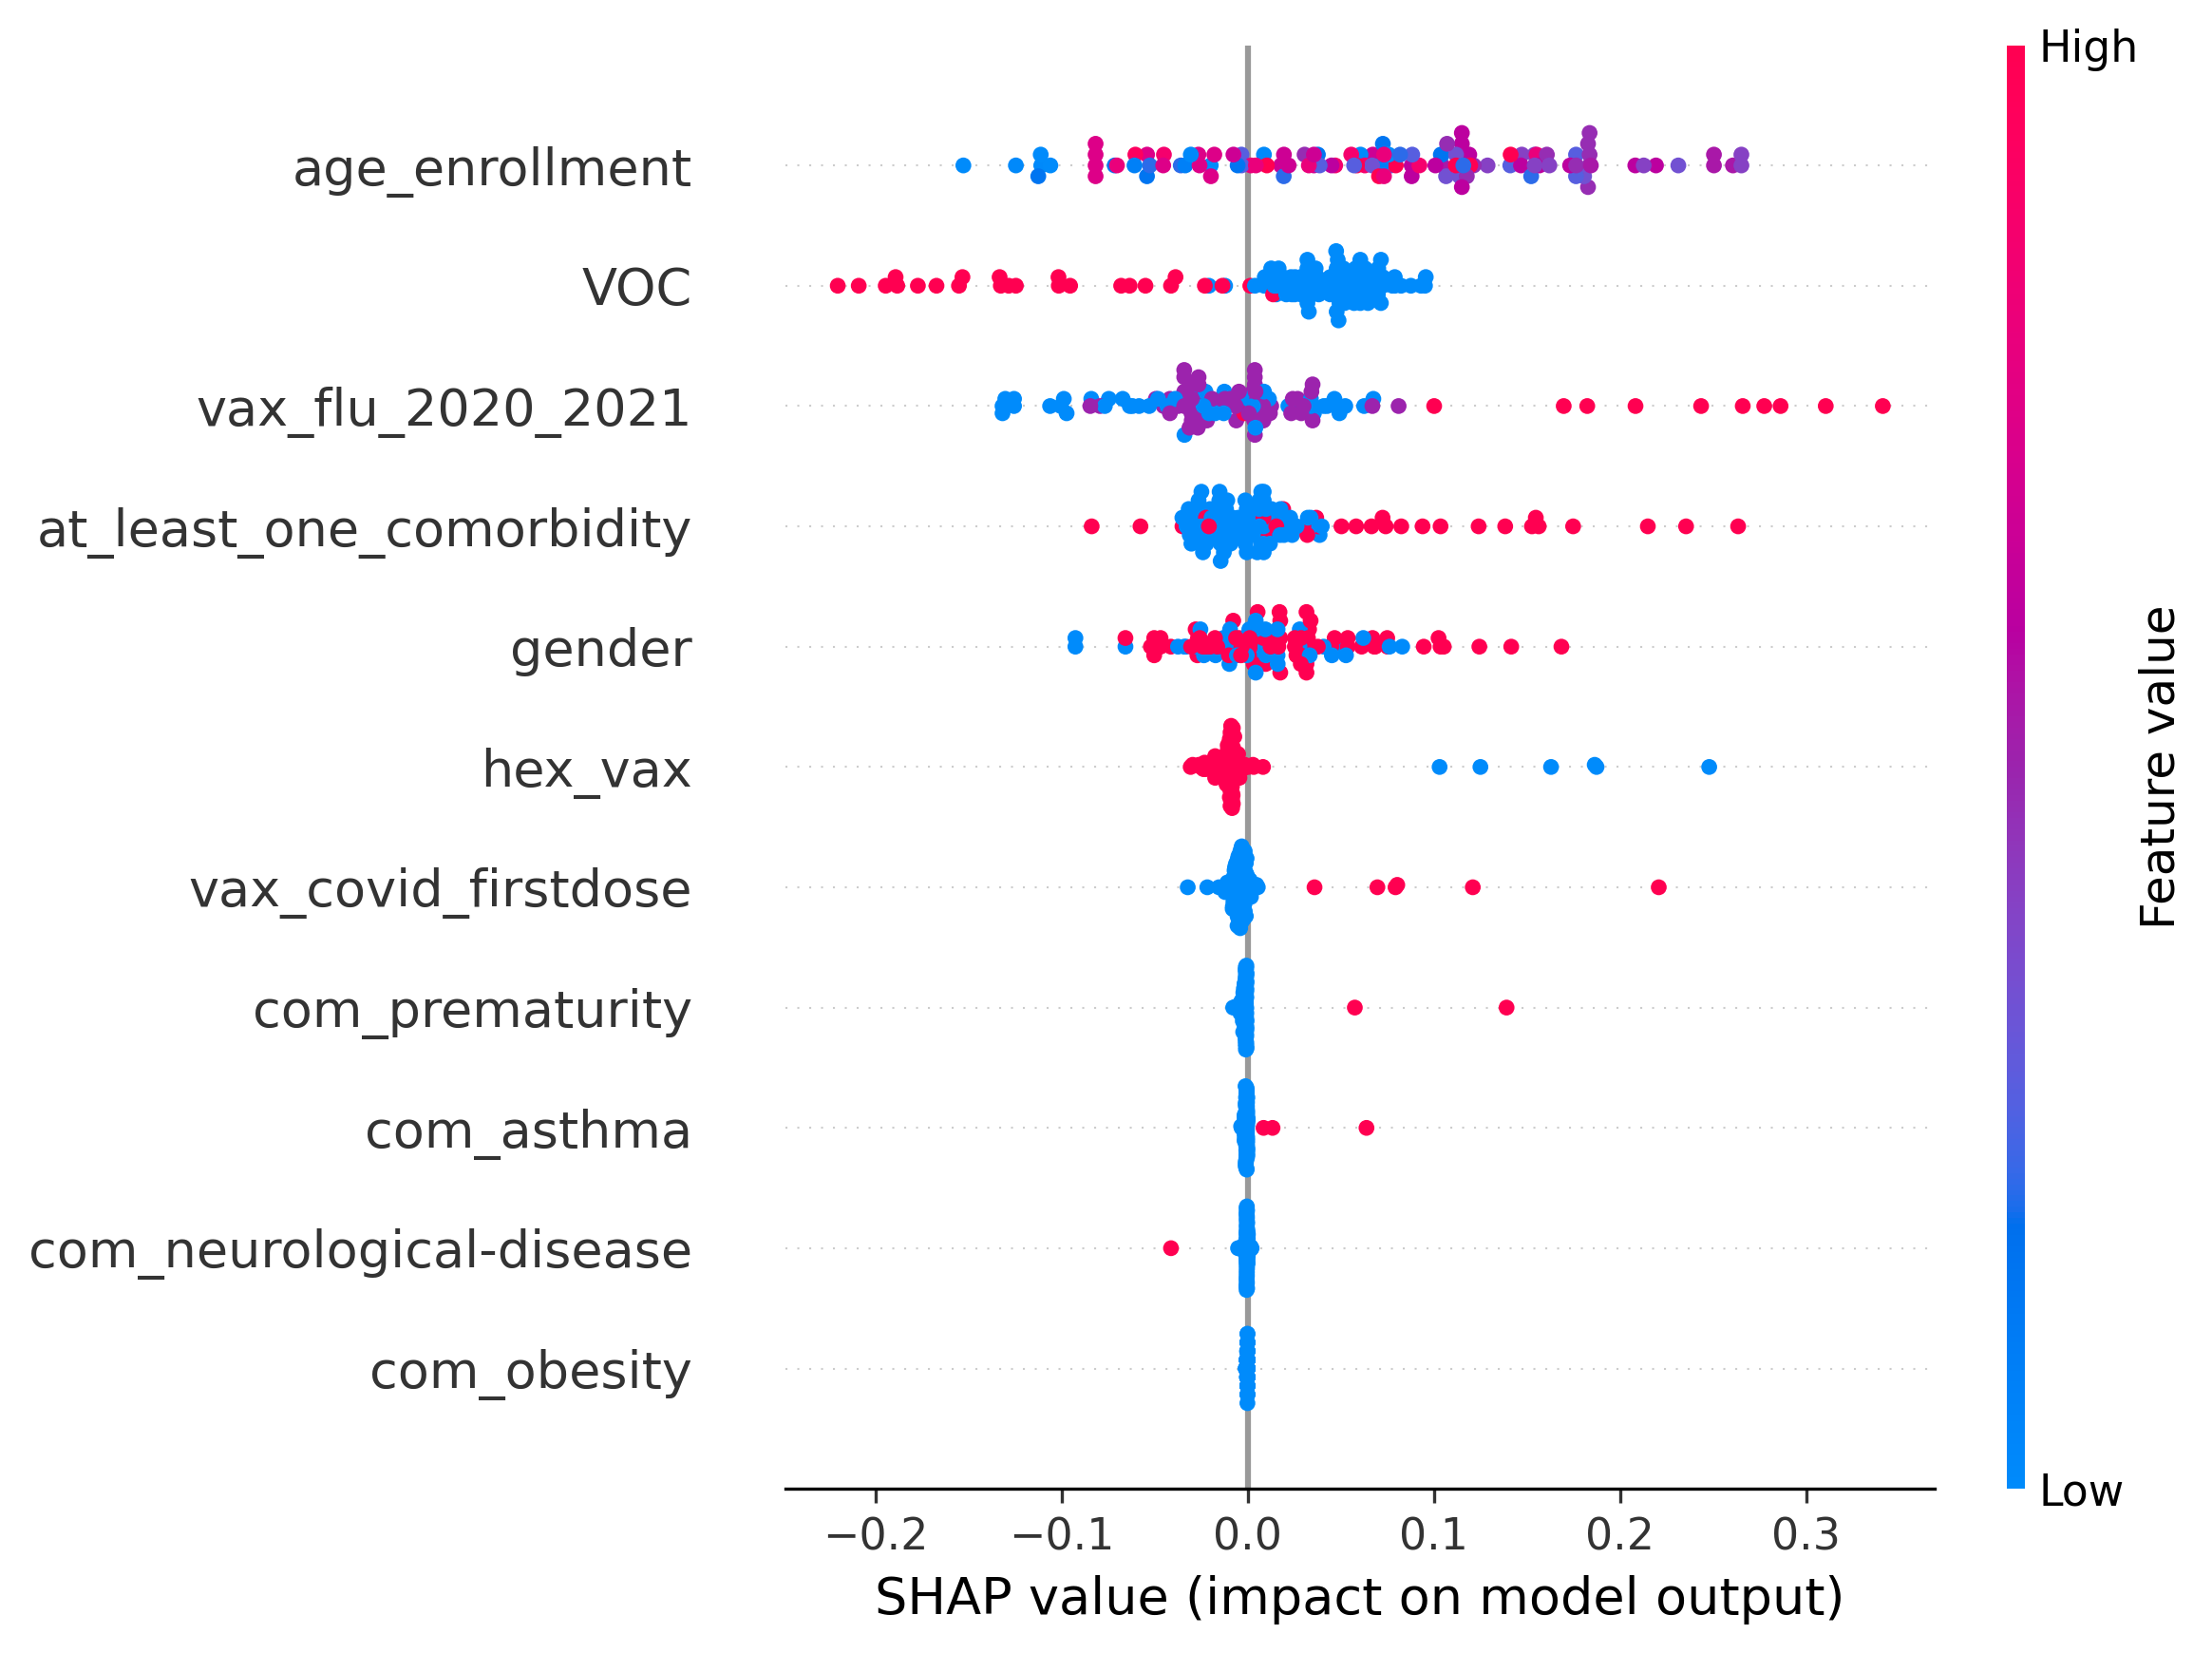

In [ ]:
class_index = 0 

shap_values_numeric = np.array([shap_values.values for shap_values in shap_values_all])
shap_values_class_mean = np.mean(shap_values_numeric, axis=0)[:, :, class_index]  # (117, 11)

plt.figure(figsize=(12, 8), dpi=300)
shap.summary_plot(
    shap_values_class_mean, 
    X_test, 
    plot_type="dot", 
    color=plt.get_cmap("coolwarm"),
    feature_names=X.columns.tolist()
)

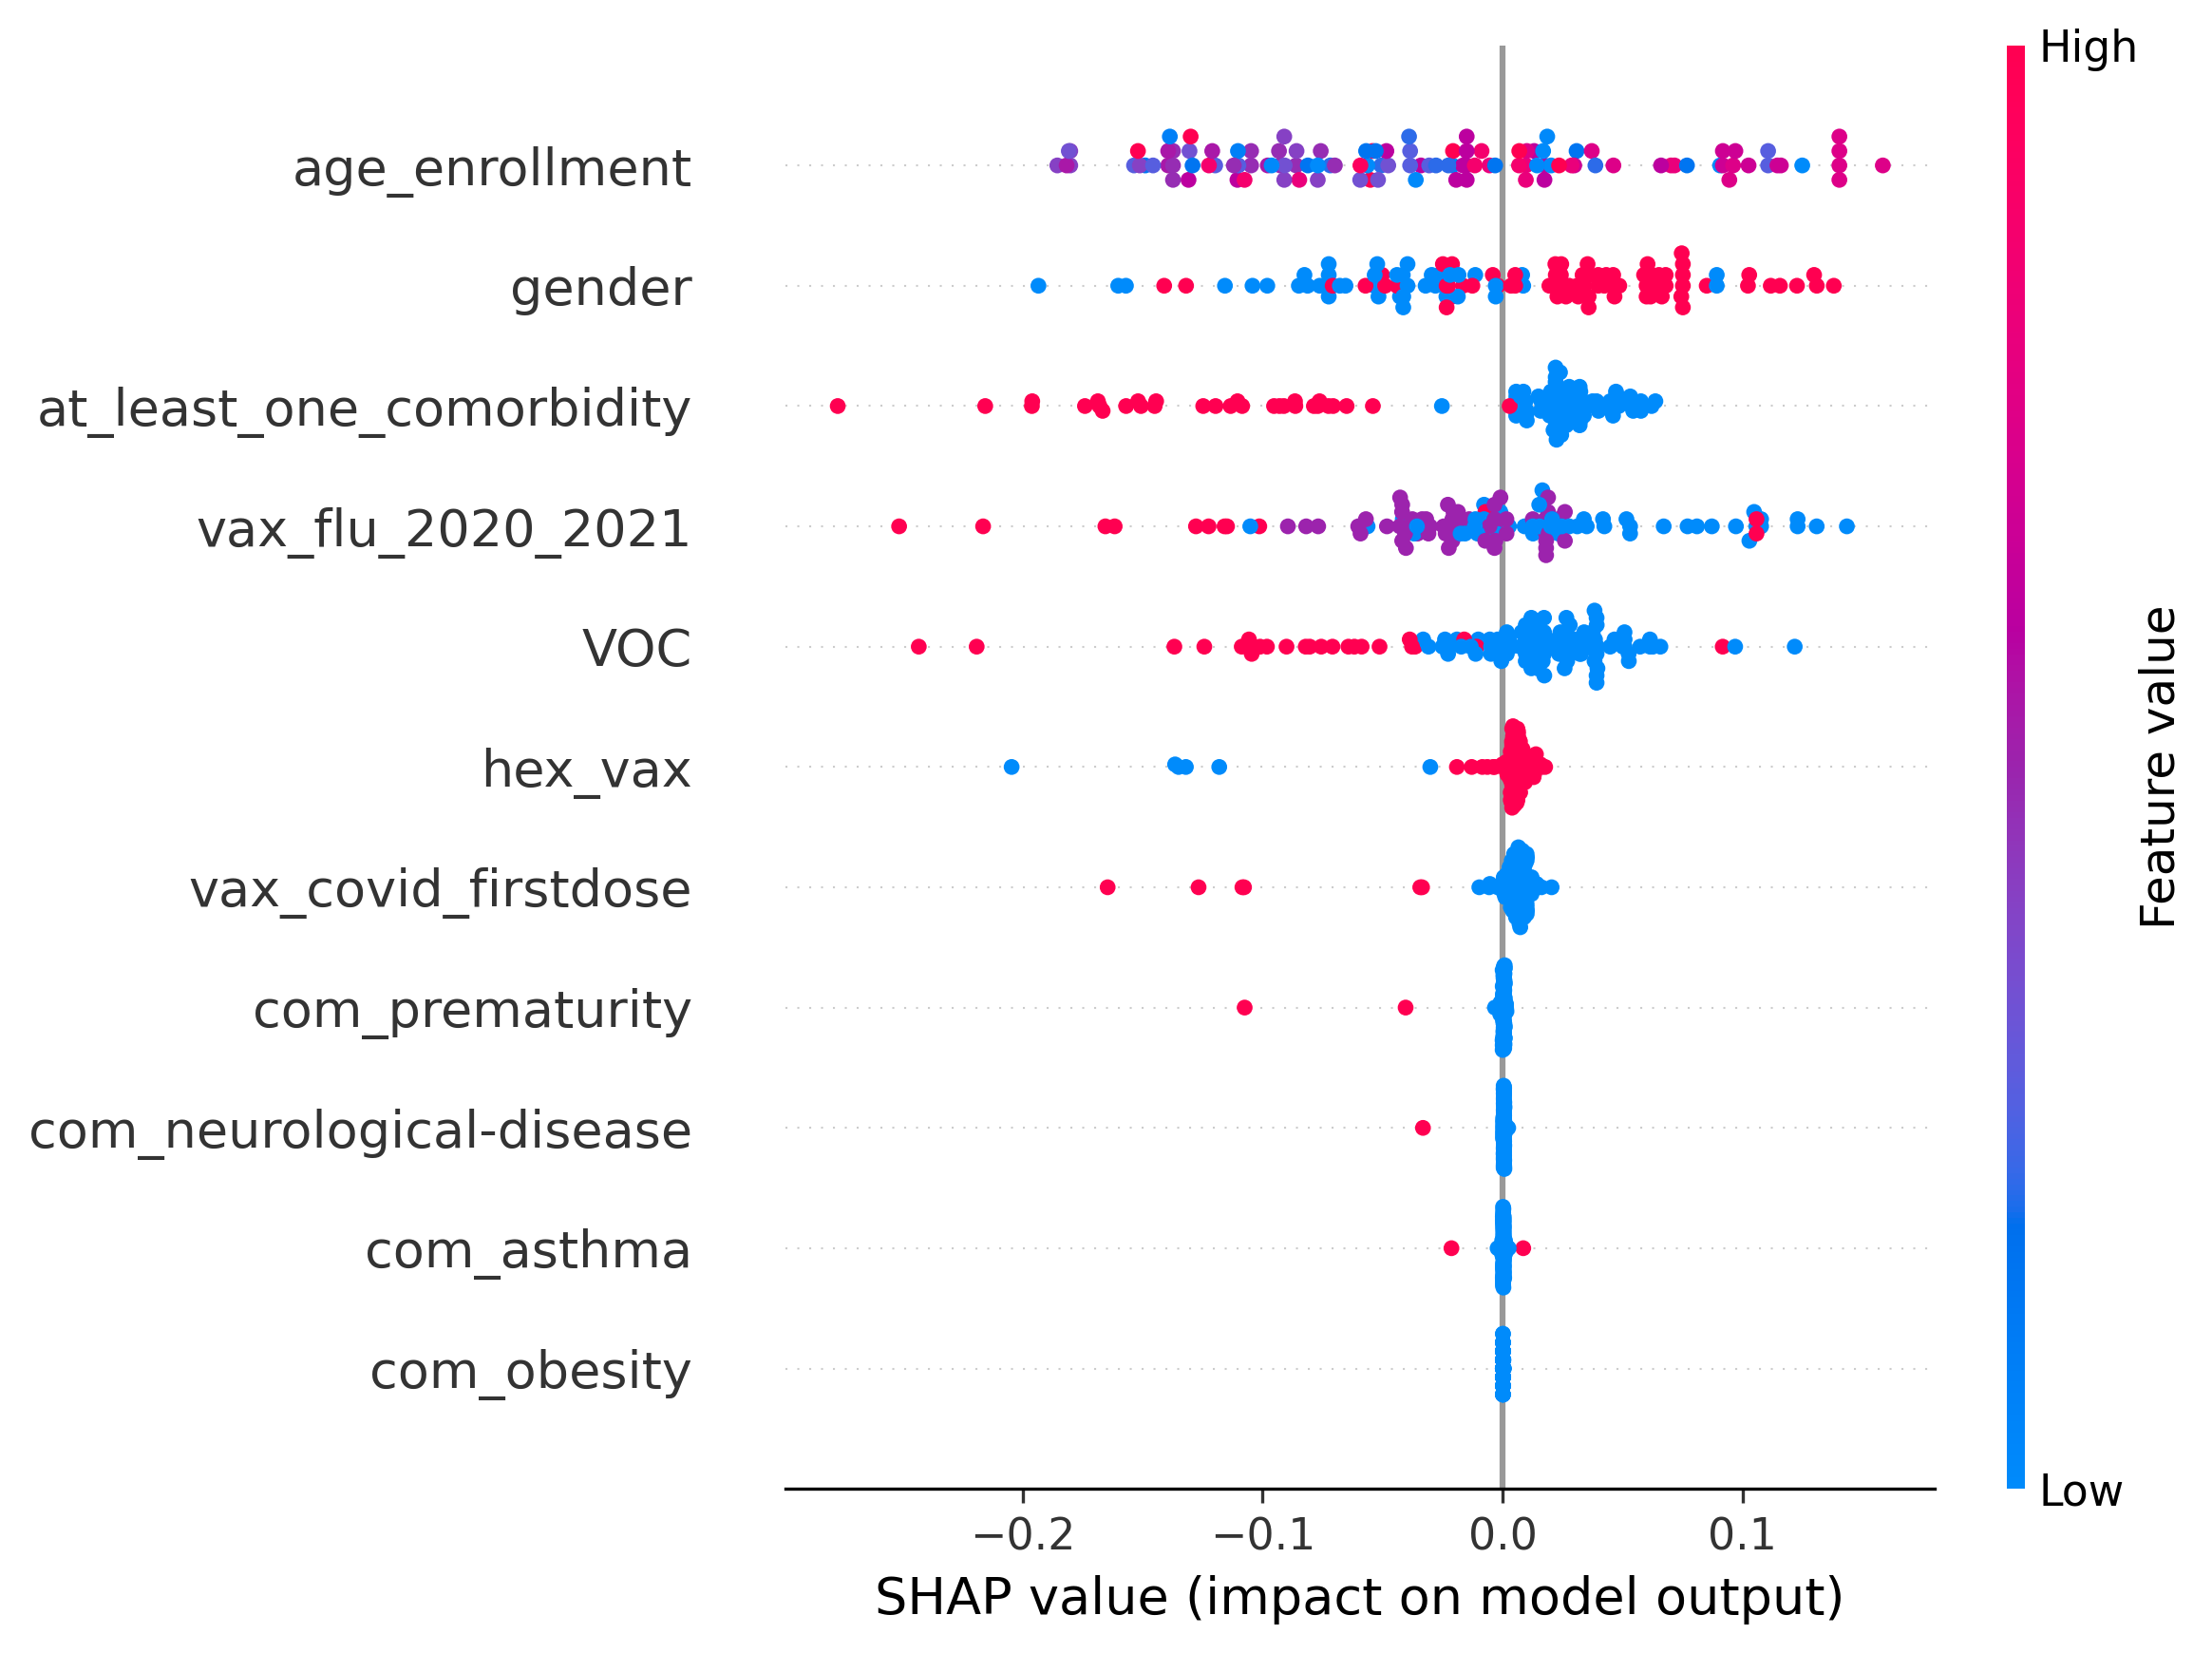

In [ ]:
class_index = 1 
shap_values_numeric = np.array([shap_values.values for shap_values in shap_values_all])
shap_values_class_mean = np.mean(shap_values_numeric, axis=0)[:, :, class_index]  # (117, 11)

plt.figure(figsize=(12, 8), dpi=300)
shap.summary_plot(
    shap_values_class_mean, 
    X_test, 
    plot_type="dot", 
    color=plt.get_cmap("coolwarm"),
    feature_names=X.columns.tolist()
)

<Figure size 3200x2400 with 0 Axes>

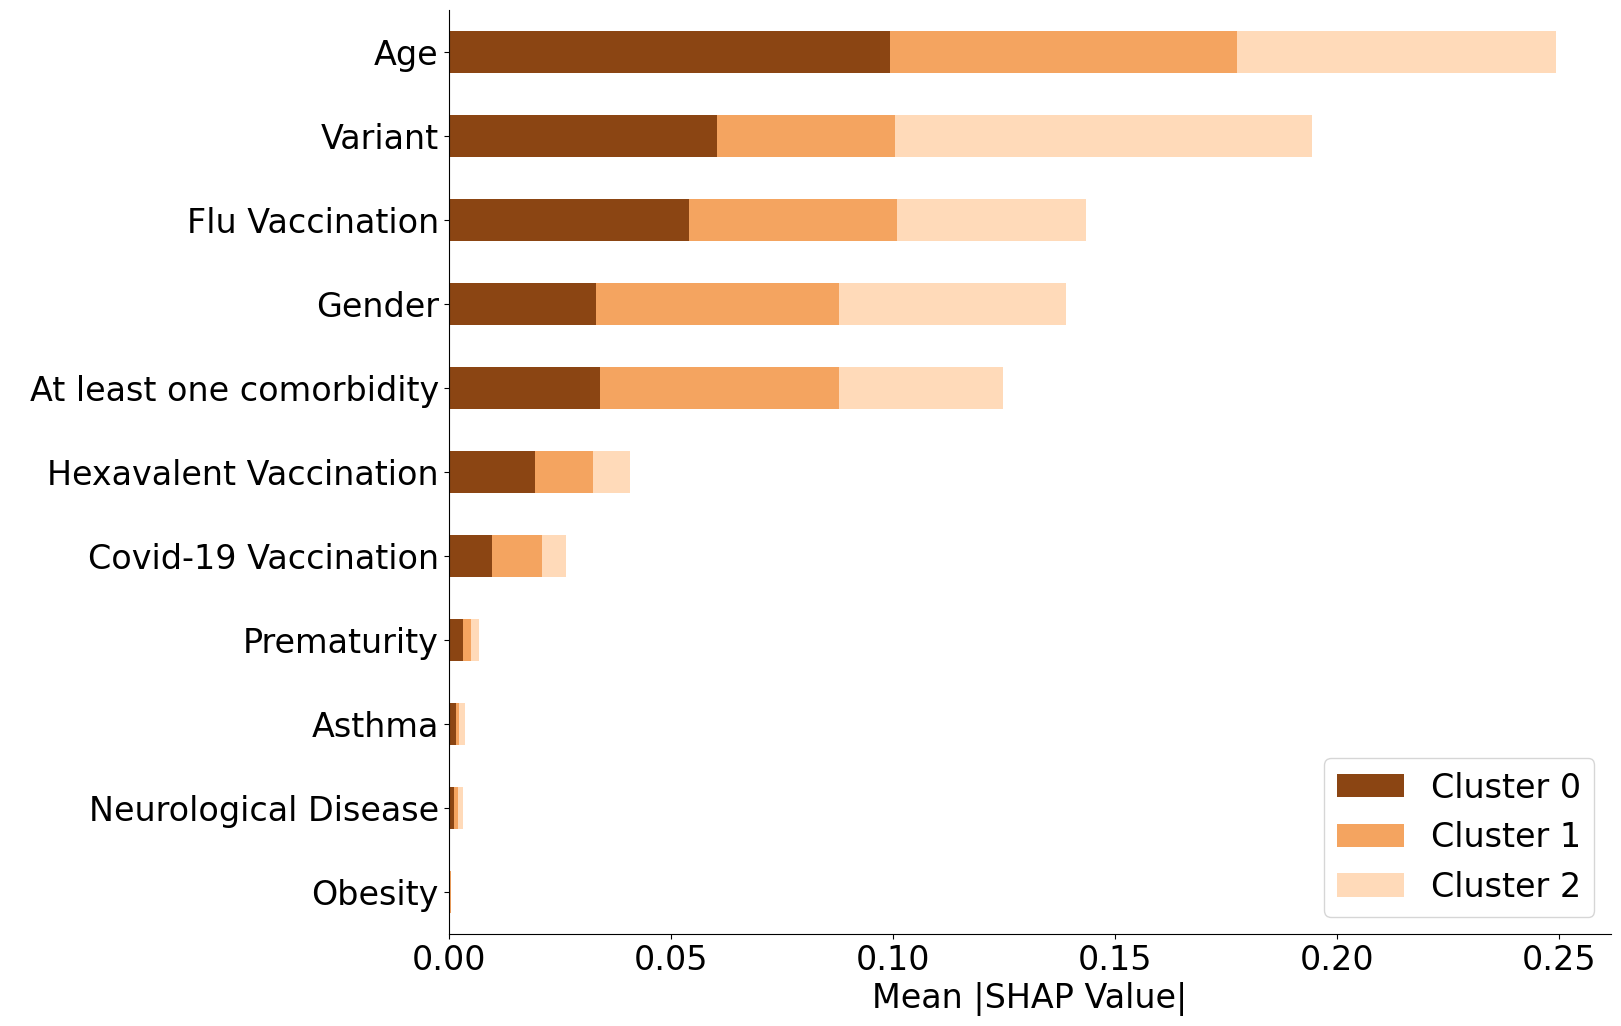

In [ ]:
# color map definition
my_cmap = ListedColormap(['saddlebrown', 'sandybrown', 'peachpuff'])
shap_values_numeric = np.array([shap_values.values for shap_values in shap_values_all])  # (5, 117, 11, 3)
shap_values_mean = np.mean(shap_values_numeric, axis=0)  # (117, 11, 3)
shap_feature_importance = np.mean(np.abs(shap_values_mean), axis=0)  # (11, 3)

sorted_indices = np.argsort(np.sum(shap_feature_importance, axis=1))
shap_feature_importance = shap_feature_importance[sorted_indices]
sorted_feature_names = np.array(X.columns.tolist())[sorted_indices] #order names

shap_df = pd.DataFrame(shap_feature_importance, 
                       index=sorted_feature_names,
                       columns=[f"Cluster {i}" for i in range(shap_feature_importance.shape[1])])

plt.figure(dpi=500)
# Plot stacked bar
shap_df.plot(kind="barh", stacked=True, figsize = (15, 12), colormap=my_cmap)
plt.ylabel(" ")
plt.xlabel("Mean |SHAP Value|", fontsize = 24)

plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.legend( loc="lower right", fontsize = 24)
# remove x spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [ ]:
shap_values_numeric = np.array([shap_values.values for shap_values in shap_values_all])  # (5, 117, 11, 3)
shap_values_mean_array = np.mean(shap_values_numeric, axis=0)  # (117, 11, 3)


shap_values_mean = np.mean(np.abs(shap_values_mean_array), axis=0)
sorted_indices = np.argsort(np.sum(shap_values_mean, axis=1))
shap_values_mean = shap_values_mean[sorted_indices]
sorted_feature_names = np.array(X.columns.tolist())[sorted_indices] #order names
shap_values_lower = np.percentile(np.abs(shap_values_mean_array), 2.5, axis=0)
shap_values_lower = shap_values_lower[sorted_indices]

shap_values_upper = np.percentile(np.abs(shap_values_mean_array), 97.5, axis=0)
shap_values_upper = shap_values_upper[sorted_indices]
print(sorted_feature_names)
print("SHAP values mean sum by feature:", shap_values_mean.sum(axis=1))
print("SHAP values lower sum by feature:", shap_values_lower.sum(axis=1))
print("SHAP values upper sum by feature:", shap_values_upper.sum(axis=1))


['com_obesity' 'com_neurological-disease' 'com_asthma' 'com_prematurity'
 'vax_covid_firstdose' 'hex_vax' 'at_least_one_comorbidity' 'gender'
 'vax_flu_2020_2021' 'VOC' 'age_enrollment']
SHAP values mean sum by feature: [0.00065311 0.00318046 0.00362064 0.00687745 0.0263466  0.0408885
 0.12482732 0.13899805 0.14354781 0.1944298  0.24927964]
SHAP values lower sum by feature: [0.00025924 0.00031192 0.00048132 0.0009982  0.00067127 0.00468023
 0.01074281 0.00667995 0.00503615 0.02965038 0.01873168]
SHAP values upper sum by feature: [0.0016153  0.00786933 0.01110099 0.01590737 0.21549429 0.3417122
 0.51248797 0.38262669 0.56540561 0.60845825 0.58342585]


In [ ]:
# Check statistics
statistics = df.groupby('Cluster').agg({
    'age_enrollment': ['mean', 'std', 'min', 'max', 'median'],
    'gender': lambda x: np.round(x.value_counts(normalize=True),2).to_dict(),  
    'hex_vax': lambda x: (x == 1).sum() / len(x), 
    'at_least_one_comorbidity': lambda x: (x == 1).sum() / len(x),
    'VOC': lambda x: np.round(x.value_counts(normalize=True), 2).to_dict()
}).reset_index()

statistics

Cluster age_enrollment                           \
                    mean       std min max median   
0       0       7.923280  4.311103   0  19    8.0   
1       1       7.982301  5.010671   0  19    8.0   
2       2       6.577778  4.716640   0  17    6.0   

                        gender   hex_vax at_least_one_comorbidity  \
                      <lambda>  <lambda>                 <lambda>   
0  {1: 0.53, 0: 0.46, 2: 0.01}  0.910053                 0.240741   
1           {1: 0.61, 0: 0.39}  0.955752                 0.212389   
2           {0: 0.51, 1: 0.49}  0.888889                 0.344444   

                            VOC  
                       <lambda>  
0  {0: 0.79, 1: 0.19, -1: 0.03}  
1   {0: 0.73, 1: 0.2, -1: 0.06}  
2  {0: 0.52, 1: 0.47, -1: 0.01}